# MSBA Capstone: Ranking Model Workflow

**Team Members:**
* Noah Branham
* David Huang
* Tamara Kempf
* Mike Marra
* Aaron Smith

### Load & Prep

In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

# Load machine learning packages
import xgboost
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomialResults
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# Set options
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:,.5f}'.format)

# Set current directory (change depending on which local machine)
path = r"/Users/dhua22/Documents/Jupyter/FileInput"
os.chdir(path)

In [2]:
# Loading data sets for base model
data_1 = pd.read_csv('ny_census.csv')
data_2 = pd.read_csv('ny_census_arcgis.csv')
data_2 = data_2.fillna(data_2.mean())
data_3 = pd.read_csv('ny_la_census.csv')
data_3 = data_3.fillna(data_3.mean())
data_4 = pd.read_csv('ny_dc_census.csv')
data_4 = data_4.fillna(data_4.mean())
data_5 = pd.read_csv('ny_census_perc.csv')
data_6 = pd.read_csv('ny_census_arcgis_perc.csv')
data_6 = data_6.fillna(data_6.mean())
data_7 = pd.read_csv('ny_la_census_perc.csv')
data_7 = data_7.fillna(data_7.mean())
data_8 = pd.read_csv('ny_dc_census_perc.csv')
data_8 = data_8.fillna(data_8.mean())

# Loading data sets for negative binomial model
nb_nyc = pd.read_csv('negbinom_nyc.csv')
nb_nyc = nb_nyc.fillna(nb_nyc.mean())
nb_la = pd.read_csv('negbinom_la.csv')
nb_la = nb_la.fillna(nb_la.mean())
nb_dc = pd.read_csv('negbinom_dc.csv')
nb_dc = nb_dc.fillna(nb_dc.mean())

# Write back to CSV
# nb_nyc.to_csv(r'/Users/dhua22/Documents/Jupyter/FileOutput/negbinom_nyc.csv', index = None, header = True)

# Drop variables
drop_X = ['GEOID', 'City', 'Borough', 'Class', 'CasualtiesPerPop', 'PedeCasualtiesCount',
          'CasualtiesPerPopDens', 'TotalInjuries', 'TotalDeaths', 'Collisions', 
          'CasualtiesCount', 'pop']

### Ranking Calculation Function

In [3]:
# Define ranking function
def panos_ranking(preds, actual):
    
    # Conditionally convert to series
    if type(preds) == np.ndarray:
        preds = pd.Series(preds)
    else:
        preds = preds
    if type(actual) == np.ndarray:
        actual = pd.Series(actual)
    else:
        actual = actual
    
    # Create ranking dataframe
    preds = preds.to_frame()
    actual = actual.to_frame()
    rank_df = pd.concat([preds.reset_index(drop = True), actual.reset_index(drop = True)], ignore_index = True, axis = 1)
    rank_df.columns = ['preds','actual']
    rank_df = rank_df.sort_values(by = 'actual', ascending = False)
    rank_df['actual_rank'] = rank_df['actual'].rank(ascending = False)
    rank_df['pred_rank'] = rank_df['preds'].rank(ascending = False)
    rank_df['PerfectScoreTotal'] = rank_df['actual'].cumsum()
    pred_df = rank_df.copy()
    pred_df = pred_df.sort_values(by = 'preds', ascending = False)
    pred_df = pred_df.drop(['PerfectScoreTotal'], axis = 1)
    final_df = pd.concat([pred_df.reset_index(drop = True), rank_df['PerfectScoreTotal'].reset_index(drop = True)], axis = 1)
    final_df['PerfectScore_Remaining_Casualties'] = final_df['actual'].sum() - final_df['PerfectScoreTotal']
    final_df['PerfectScore_Random'] = final_df['PerfectScore_Remaining_Casualties'] / (final_df['actual'].count() - final_df['pred_rank'] + 1)
    final_df['Perfect_GainOverRandom'] = final_df['PerfectScoreTotal'].diff() - final_df['PerfectScore_Random'].shift(1)
    final_df['Perfect_GainOverRandom'].iloc[0] = final_df['PerfectScoreTotal'].iloc[0] - final_df['PerfectScore_Random'].iloc[0]
    final_df['Perfect_TotalGainOverRandom'] = final_df['Perfect_GainOverRandom']
    final_df['Perfect_TotalGainOverRandom'].iloc[1:] = final_df['Perfect_TotalGainOverRandom'].cumsum()
    final_df['Total_Actual'] = final_df['actual'].cumsum()
    final_df['Remaining Casualties'] = final_df['actual'].sum()
    final_df['Remaining Casualties'].iloc[1:] = final_df['actual'].sum() - final_df['Total_Actual'].shift(1)
    final_df['RandomScore'] = final_df['Remaining Casualties'] / (final_df['actual'].count() - final_df['pred_rank']+1)
    final_df['GainOverRandom'] = final_df['actual'] - final_df['RandomScore']
    final_df['TotalGainOverRandom'] = final_df['GainOverRandom']
    final_df['TotalGainOverRandom'].iloc[1:] = final_df['GainOverRandom'].cumsum()
    final_df['Gain_Over_PerfectGain'] = final_df['TotalGainOverRandom'] / final_df['Perfect_TotalGainOverRandom']
    return final_df

### Ranking Modeling Function

In [4]:
# Define workflow function
def run_models(city, target_y, k):

    # Define data input
    if city == 'NYCc' and target_y == 'CasualtiesCount':
        df = data_1[data_1['pop'] >= 200]
        X = df.drop(drop_X, axis = 1)
        y = df[target_y]
        strat = df[['Borough', 'Class']].values
        X_train, X_test, y_train, y_test = train_test_split(
                X, y, stratify = strat, test_size = 0.30, random_state = 1234)
    elif city == 'NYCr' and target_y == 'CasualtiesCount':
        df = data_2[data_1['pop'] >= 200]
        X = df.drop(drop_X, axis = 1)
        y = df[target_y]
        strat = df[['Borough', 'Class']].values
        X_train, X_test, y_train, y_test = train_test_split(
                X, y, stratify = strat, test_size = 0.30, random_state = 1234)
    elif city == 'LA' and target_y == 'CasualtiesCount':
        df = data_3
        target_city = df['City'] == city
        train_city = df[-target_city]
        train_city = train_city[train_city['pop'] >= 200]
        test_city = df[target_city]
        test_city = test_city[test_city['pop'] >= 200]
        X_train = train_city.drop(drop_X, axis=1)
        X_test = test_city.drop(drop_X, axis=1)
        y_train = train_city[target_y]
        y_test = test_city[target_y]
    elif city == 'DC' and target_y == 'CasualtiesCount':
        df = data_4
        target_city = df['City'] == city
        train_city = df[-target_city]
        train_city = train_city[train_city['pop'] >= 200]
        test_city = df[target_city]
        X_train = train_city.drop(drop_X, axis=1)
        X_test = test_city.drop(drop_X, axis=1)
        y_train = train_city[target_y]
        y_test = test_city[target_y]
    elif city == 'NYCc' and target_y == 'CasualtiesPerPop':
        df = data_5[data_1['pop'] >= 200]
        X = df.drop(drop_X, axis=1)
        y = df[target_y]
        strat = df[['Borough', 'Class']].values
        X_train, X_test, y_train, y_test = train_test_split(
                X, y, stratify = strat, test_size = 0.30, random_state = 1234)
    elif city == 'NYCr' and target_y == 'CasualtiesPerPop':
        df = data_6[data_1['pop'] >= 200]
        X = df.drop(drop_X, axis=1)
        y = df[target_y]
        strat = df[['Borough', 'Class']].values
        X_train, X_test, y_train, y_test = train_test_split(
                X, y, stratify = strat, test_size = 0.30, random_state = 1234)
    elif city == 'LA' and target_y == 'CasualtiesPerPop':
        df = data_7
        target_city = df['City'] == city
        train_city = df[-target_city]
        train_city = train_city[train_city['pop'] >= 200]
        test_city = df[target_city]
        test_city = test_city[test_city['pop'] >= 200]
        X_train = train_city.drop(drop_X, axis=1)
        X_test = test_city.drop(drop_X, axis=1)
        y_train = train_city[target_y]
        y_test = test_city[target_y]
    elif city == 'DC' and target_y == 'CasualtiesPerPop':
        df = data_8
        target_city = df['City'] == city
        train_city = df[-target_city]
        train_city = train_city[train_city['pop'] >= 200]
        test_city = df[target_city]
        X_train = train_city.drop(drop_X, axis=1)
        X_test = test_city.drop(drop_X, axis=1)
        y_train = train_city[target_y]
        y_test = test_city[target_y]

    # Train and test negative binomial model
    negbinom = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial()).fit()
    negbinom_pred = negbinom.predict(X_test)
    negbinom_rmse = rmse(y_test, negbinom_pred)
    negbinom_mae = MAE(y_test, negbinom_pred)
    negbinom_ranking = panos_ranking(negbinom_pred, y_test)

    # Train, validate, and test k-nearest neighbors model
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.fit_transform(X_test)
    knn = KNeighborsRegressor(n_neighbors = 6)
    knn_cv = - cross_val_score(knn, X_train_scaled, y_train, cv = k, scoring = 'neg_mean_squared_error').mean()
    knn.fit(X_train_scaled, y_train)
    knn_pred = knn.predict(X_test_scaled)
    knn_rmse = np.sqrt(MSE(y_test, knn_pred))
    knn_mae = MAE(y_test, knn_pred)
    knn_ranking = panos_ranking(knn_pred, y_test)

    # Train, validate, and test random forest model
    rf = RandomForestRegressor(n_estimators = 500, max_depth = 5, max_features = 0.5)
    rf_cv = - cross_val_score(rf, X_train, y_train, cv = k, scoring = 'neg_mean_squared_error').mean()
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_rmse = np.sqrt(MSE(y_test, rf_pred))
    rf_mae = MAE(y_test, rf_pred)
    rf_ranking = panos_ranking(rf_pred, y_test)

    # Train and test xgboost model
    xgb = xgboost.XGBRegressor(n_estimators = 500, learning_rate = 0.08, gamma = 0, colsample_bytree = 0.5, max_depth = 5)
    kfold = KFold(n_splits = k)
    xgb_cv = - cross_val_score(xgb, X_train, y_train, cv = kfold, scoring = 'neg_mean_squared_error').mean()
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_rmse = np.sqrt(MSE(y_test, xgb_pred))
    xgb_mae = MAE(y_test, xgb_pred)
    xgb_ranking = panos_ranking(xgb_pred, y_test)
    
    # Output ranking data to CSV files
    
    
    
    # Print iteration titles
    print(" ")
    print("======================================================================")
    if city == 'NYCc' and target_y == 'CasualtiesCount':
        print("ITERATION:")
        print("Train & Test on NYC with Census Features")
        print("Target Variable:", target_y)
        print(" ")
    elif city == 'NYCr' and target_y == 'CasualtiesCount':
        print("ITERATION:")
        print("Train & Test on NYC with Census & Road Features")
        print("Target Variable:", target_y)
        print(" ")
    elif city == 'LA' and target_y == 'CasualtiesCount':
        print("ITERATION:")
        print("Train on NYC & Test on LA with Census Features")
        print("Target Variable:", target_y)
        print(" ")
    elif city == 'DC' and target_y == 'CasualtiesCount':
        print("ITERATION:")
        print("Train on NYC & Test on DC with Census Features")
        print("Target Variable:", target_y)
        print(" ")
    elif city == 'NYCc' and target_y == 'CasualtiesPerPop':
        print("ITERATION:")
        print("Train & Test on NYC with Proportioned Census Features")
        print("Target Variable:", target_y)
        print(" ")
    elif city == 'NYCr' and target_y == 'CasualtiesPerPop':
        print("ITERATION:")
        print("Train & Test on NYC with Proportioned Census & Road Features")
        print("Target Variable:", target_y)
        print(" ")
    elif city == 'LA' and target_y == 'CasualtiesPerPop':
        print("ITERATION:")
        print("Train on NYC & Test on LA with Proportioned Census")
        print("Target Variable:", target_y)
        print(" ")
    elif city == 'DC' and target_y == 'CasualtiesPerPop':
        print("ITERATION:")
        print("Train on NYC & Test on DC with Proportioned Census & Road Features")
        print("Target Variable:", target_y)
        print(" ")
    
    # Print model scores
    print("======================================================================")
    print("MODEL PERFORMANCE")
    print(" ")
    print("TARGET BASELINE")
    print("  Shape of training data:", X_train.shape)
    print("  Shape of test data:", X_test.shape)
    print("  Test Set Stdev: {:.2f}".format(np.std(y_test)))
    print("  Test Set MAE: {:.2f}".format(abs(y_test - np.mean(y_test)).mean()))
    print(" ")  
    results_dict = {
            'Model' : ['Negative Binomial', 'K-Nearest Neighbors', 'Random Forest', 'XGBoost'],
            'CV RMSE' : ['n/a', np.sqrt(knn_cv), np.sqrt(rf_cv), np.sqrt(xgb_cv)],
            'Prediction RMSE' : [negbinom_rmse, knn_rmse, rf_rmse, xgb_rmse],
            'Prediction MAE' : [negbinom_mae, knn_mae, rf_mae, xgb_mae]
            }
    results_df = pd.DataFrame.from_dict(results_dict)
    print(results_df)
    print(" ")  

    # Print variable importance from Random Forest & XGBoost
    print("======================================================================")
    print("FEATURE IMPORTANCE")
    print(" ")
    print("RF Top 10 Features")
    importances_rf = pd.Series(data = rf.feature_importances_, index = X_train.columns)
    importances_rf_sorted = importances_rf.sort_values(ascending = False)[:10]
    print(importances_rf_sorted)
    print(" ")
    print("XGBoost Top 10 Features")
    importances_xgb = pd.Series(data = xgb.feature_importances_, index = X_train.columns)
    importances_xgb_sorted = importances_xgb.sort_values(ascending = False)[:10]
    print(importances_xgb_sorted)
    
    # Random Forest Feature Importance Chart
    #     importances_rf = pd.Series(data = rf.feature_importances_, index = X_train.columns)
    #     importances_rf_sorted = importances_rf.sort_values(ascending = False)[-10:]
    #     importances_sorted.plot(kind = 'barh', color = 'lightblue', figsize = (5, 3))
    #     plt.ylabel('Features')
    #     plt.title('Random Forest Top 10 Features')
    #     plt.show()
    
    # XGBoost Feature Importance Chart
    #     fig, ax = plt.subplots(figsize = (5, 3))
    #     plot_importance(
    #             xgb,
    #             max_num_features = 10,
    #             importance_type = "weight",
    #             title = 'XGBoost Top 10 Features',
    #             ax = ax)
    #     plt.show()
    print(" ")

    # Print ranking performance chart
    print("======================================================================")
    print("RANKING PERFORMANCE")
    plt.plot(
        negbinom_ranking['pred_rank'],
        negbinom_ranking['Perfect_TotalGainOverRandom'],
        color ='blue',
        label = 'Perfect Ranking')
    plt.plot(
        negbinom_ranking['pred_rank'],
        negbinom_ranking['TotalGainOverRandom'],
        color ='red',
        label = 'Neg Binom Ranking')
    plt.plot(
        negbinom_ranking['pred_rank'],
        knn_ranking['TotalGainOverRandom'],
        color ='green',
        label = 'K-NN Ranking')
    plt.plot(
        negbinom_ranking['pred_rank'],
        rf_ranking['TotalGainOverRandom'],
        color ='orange',
        label = 'Random Forest Ranking')
    plt.plot(
        negbinom_ranking['pred_rank'],
        xgb_ranking['TotalGainOverRandom'],
        color = 'gray',
        label = 'XGBoost Ranking')
    plt.xlabel('Predicted Rank Position')
    if target_y == 'CasualtiesCount':
        plt.ylabel('Cumulative Total Casualties')
    elif target_y == 'CasualtiesPerPop':
        plt.ylabel('Cumulative Total Casualties Per Person')
    plt.legend()
    if city == 'NYCc' and target_y == 'CasualtiesCount':
        plt.title('Train & Test on NYC with Census Features')
    elif city == 'NYCr' and target_y == 'CasualtiesCount':
        plt.title('Train & Test on NYC with Census & Road Features')
    elif city == 'LA' and target_y == 'CasualtiesCount':
        plt.title('Train on NYC & Test on LA with Census Features')
    elif city == 'DC' and target_y == 'CasualtiesCount':
        plt.title('Train on NYC & Test on DC with Census Features')
    elif city == 'NYCc' and target_y == 'CasualtiesPerPop':
        plt.title('Train & Test on NYC with Proportioned Census Features')
    elif city == 'NYCr' and target_y == 'CasualtiesPerPop':
        plt.title('Train & Test on NYC with Proportioned Census & Road Features')
    elif city == 'LA' and target_y == 'CasualtiesPerPop':
        plt.title('Train on NYC & Test on LA with Proportioned Census Features')
    elif city == 'DC' and target_y == 'CasualtiesPerPop':
        plt.title('Train on NYC & Test on DC with Proportioned Census Features')
    plt.figure(figsize = (6, 6))
    plt.show()

### Regression Modeling for Relationship Discovery

In [5]:
# Define negative binomial model function that produces summary for analysis
def run_negbinom(area, target_y, features):
    
    # Define features to include
    if features == 'transpo':
        keep = ['pop_dens', 'trav_cars', 'trav_trans', 'trav_motorcycle', 'trav_bike', 
                'trav_walk', 'trav_home']
    elif features == 'demog':
        keep = ['pop_dens', 'race_white', 'race_minority', 'female', 'age_genz', 
                'age_millenial', 'age_genx', 'age_boomer', 'age_retiree', 'divsep', 
                'widowed', 'median_age', 'not_us_citizen', 'median_earnings', 
                'edu_lowedu', 'edu_hsged', 'edu_bs', 'edu_grad', 'unemp', 'below_pov']
    elif features == 'road':
        keep = ['road_maxspeed', 'road_meanspeed', 'road_maxlength', 'road_minlength', 
                'road_meanlength', 'road_totlanes', 'road_maxlanes', 'road_iri', 'road_bumps', 
                'road_aadt', 'road_sumlength', 'road_pci', 'road_pavewidth', 'road_vc', 'road_q']
    elif features == 'census':
        keep = ['pop_dens', 'race_white', 'race_minority', 'female', 'age_genz', 
                'age_millenial', 'age_genx', 'age_boomer', 'age_retiree', 'divsep', 
                'widowed', 'median_age', 'not_us_citizen', 'median_earnings', 'trav_cars', 
                'trav_trans', 'trav_motorcycle', 'trav_bike', 'trav_walk', 'trav_home', 
                'edu_lowedu', 'edu_hsged', 'edu_bs', 'edu_grad', 'unemp', 'below_pov']
    elif features == 'hypoth':
        keep = ['pop_dens', 'median_age', 'median_earnings', 'trav_cars', 'trav_trans', 'trav_bike', 
                'trav_walk', 'below_pov', 'race_minority']

    # Define city input
    if area == 'NYC': 
        df = nb_nyc[nb_nyc['pop'] >= 200].copy()
    elif area == 'Bronx':
        df = nb_nyc[nb_nyc['Borough'] == 'Bronx']
        df = df[df['pop'] >= 200].copy()
    elif area == 'Brooklyn':
        df = nb_nyc[nb_nyc['Borough'] == 'Brooklyn']
        df = df[df['pop'] >= 200].copy()
    elif area == 'Manhattan':
        df = nb_nyc[nb_nyc['Borough'] == 'Manhattan']
        df = df[df['pop'] >= 200].copy()
    elif area == 'Queens':
        df = nb_nyc[nb_nyc['Borough'] == 'Queens']
        df = df[df['pop'] >= 200].copy()
    elif area == 'Staten Island':
        df = nb_nyc[nb_nyc['Borough'] == 'Staten Island']
        df = df[df['pop'] >= 200].copy()
    elif area == 'LA':
        df = nb_la
        df = nb_la[nb_la['pop'] >= 200].copy()
    elif area == 'DC':
        df = nb_dc.copy()
        
    # Define data input
    if (target_y == 'CasualtiesCount' or target_y == 'PedeCasualtiesCount' or 
        target_y == 'CyclCasualtiesCount' or  target_y == 'MotrCasualtiesCount'):
        df = df[df['Type'] == 'Count']
        X = df[keep]
        y = df[target_y]
    elif (target_y == 'CasualtiesPerPop' or target_y == 'PedeCasualtiesPerPop' or 
          target_y == 'CyclCasualtiesPerPop' or target_y == 'MotrCasualtiesPerPop'):
        df = df[df['Type'] == 'Percentage']
        X = df[keep]
        y = df[target_y]
    elif target_y == 'Collisions':
        df = df[df['Type'] == 'Count']
        X = df[keep]
        y = df[target_y]
    
    ### Train and test negative binomial model
    Xa = sm.add_constant(X)
    negbinom = sm.GLM(y, Xa, family = sm.families.NegativeBinomial()).fit()
    negbinom_pred = negbinom.predict(Xa)
    negbinom_ranking = panos_ranking(negbinom_pred, y)
    
    ### Print all outputs
    print("==============================================================================")
    print("AIC:", NegativeBinomialResults.aic(negbinom))
    print("==============================================================================")
    print(negbinom.summary())
    print("RANKING PERFORMANCE")
    plt.plot(
        negbinom_ranking['pred_rank'],
        negbinom_ranking['Perfect_TotalGainOverRandom'],
        color ='blue',
        label = 'Perfect Ranking')
    plt.plot(
        negbinom_ranking['pred_rank'],
        negbinom_ranking['TotalGainOverRandom'],
        color ='red',
        label = 'Neg Binom Ranking')
    plt.xlabel('Predicted Rank Position')
    plt.ylabel('Cumulative Gain Score')
    plt.legend()
    plt.figure(figsize = (5, 4))
    plt.show() 

In [6]:
# Define OLS model function that produces summary for analysis
def run_ols(area, target_y, features):
    
    # Define features to include
    if features == 'transpo':
        keep = ['pop_dens', 'trav_cars', 'trav_trans', 'trav_motorcycle', 'trav_bike', 
                'trav_walk', 'trav_home']
    elif features == 'demog':
        keep = ['pop_dens', 'race_white', 'race_minority', 'female', 'age_genz', 
                'age_millenial', 'age_genx', 'age_boomer', 'age_retiree', 'divsep', 
                'widowed', 'median_age', 'not_us_citizen', 'median_earnings', 
                'edu_lowedu', 'edu_hsged', 'edu_bs', 'edu_grad', 'unemp', 'below_pov']
    elif features == 'road':
        keep = ['road_maxspeed', 'road_meanspeed', 'road_maxlength', 'road_minlength', 
                'road_meanlength', 'road_totlanes', 'road_maxlanes', 'road_iri', 'road_bumps', 
                'road_aadt', 'road_sumlength', 'road_pci', 'road_pavewidth', 'road_vc', 'road_q']
    elif features == 'census':
        keep = ['pop_dens', 'race_white', 'race_minority', 'female', 'age_genz', 
                'age_millenial', 'age_genx', 'age_boomer', 'age_retiree', 'divsep', 
                'widowed', 'median_age', 'not_us_citizen', 'median_earnings', 'trav_cars', 
                'trav_trans', 'trav_motorcycle', 'trav_bike', 'trav_walk', 'trav_home', 
                'edu_lowedu', 'edu_hsged', 'edu_bs', 'edu_grad', 'unemp', 'below_pov']
    elif features == 'hypoth':
        keep = ['pop_dens', 'median_age', 'median_earnings', 'trav_cars', 'trav_trans', 'trav_bike', 
                'trav_walk', 'below_pov', 'race_minority']

    # Define city input
    if area == 'NYC': 
        df = nb_nyc[nb_nyc['pop'] >= 200].copy()
    elif area == 'Bronx':
        df = nb_nyc[nb_nyc['Borough'] == 'Bronx']
        df = df[df['pop'] >= 200].copy()
    elif area == 'Brooklyn':
        df = nb_nyc[nb_nyc['Borough'] == 'Brooklyn']
        df = df[df['pop'] >= 200].copy()
    elif area == 'Manhattan':
        df = nb_nyc[nb_nyc['Borough'] == 'Manhattan']
        df = df[df['pop'] >= 200].copy()
    elif area == 'Queens':
        df = nb_nyc[nb_nyc['Borough'] == 'Queens']
        df = df[df['pop'] >= 200].copy()
    elif area == 'Staten Island':
        df = nb_nyc[nb_nyc['Borough'] == 'Staten Island']
        df = df[df['pop'] >= 200].copy()
    elif area == 'LA':
        df = nb_la
        df = nb_la[nb_la['pop'] >= 200].copy()
    elif area == 'DC':
        df = nb_dc.copy()
        
    # Define data input
    if (target_y == 'CasualtiesCount' or target_y == 'PedeCasualtiesCount' or 
        target_y == 'CyclCasualtiesCount' or  target_y == 'MotrCasualtiesCount'):
        df = df[df['Type'] == 'Count']
        X = df[keep]
        y = df[target_y]
    elif (target_y == 'CasualtiesPerPop' or target_y == 'PedeCasualtiesPerPop' or 
          target_y == 'CyclCasualtiesPerPop' or target_y == 'MotrCasualtiesPerPop'):
        df = df[df['Type'] == 'Percentage']
        X = df[keep]
        y = df[target_y]
    elif target_y == 'Collisions':
        df = df[df['Type'] == 'Count']
        X = df[keep]
        y = df[target_y]
    
    ### Train and test negative binomial model
    Xa = sm.add_constant(X)
    ols = sm.OLS(y, Xa).fit()
    ols_pred = ols.predict(Xa)
    ols_ranking = panos_ranking(ols_pred, y)
    
    ### Print all outputs
    print("==============================================================================")
    print(ols.summary())
    print("==============================================================================")
    print("RANKING PERFORMANCE")
    plt.plot(
        ols_ranking['pred_rank'],
        ols_ranking['Perfect_TotalGainOverRandom'],
        color ='blue',
        label = 'Perfect Ranking')
    plt.plot(
        ols_ranking['pred_rank'],
        ols_ranking['TotalGainOverRandom'],
        color ='red',
        label = 'OLS Ranking')
    plt.xlabel('Predicted Rank Position')
    plt.ylabel('Cumulative Gain Score')
    plt.legend()
    plt.figure(figsize = (5, 4))
    plt.show() 

### Run Models

**run_models() instructions:**
* city: select 'NYCc' (census only), 'NYCr' (census & road features), 'LA', or 'DC'
* target_y: select 'CasualtiesCount' or 'CasualtiesPerPop'
* k: select number of folds for cross validation

 
ITERATION:
Train & Test on NYC with Proportioned Census Features
Target Variable: CasualtiesPerPop
 
MODEL PERFORMANCE
 
TARGET BASELINE
  Shape of training data: (1470, 26)
  Shape of test data: (630, 26)
  Test Set Stdev: 0.04
  Test Set MAE: 0.02
 
                 Model CV RMSE  Prediction RMSE  Prediction MAE
0    Negative Binomial     n/a          0.03032         0.01757
1  K-Nearest Neighbors 0.04541          0.03356         0.01794
2        Random Forest 0.03940          0.03060         0.01767
3              XGBoost 0.04102          0.02904         0.01684
 
FEATURE IMPORTANCE
 
RF Top 10 Features
pop_dens         0.41918
female           0.07823
edu_hsged        0.05030
trav_cars        0.04169
not_us_citizen   0.04002
age_boomer       0.03894
trav_trans       0.03230
widowed          0.02730
age_genx         0.02324
divsep           0.02102
dtype: float64
 
XGBoost Top 10 Features
pop_dens         0.21569
edu_hsged        0.06676
trav_trans       0.05554
median_age       0

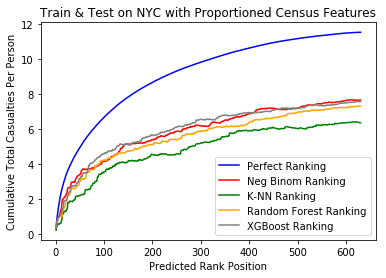

<Figure size 432x432 with 0 Axes>

In [12]:
# NYC census data
run_models(
    city = 'NYCc', 
    target_y = 'CasualtiesPerPop', 
    k = 5
)

 
ITERATION:
Train & Test on NYC with Proportioned Census & Road Features
Target Variable: CasualtiesPerPop
 
MODEL PERFORMANCE
 
TARGET BASELINE
  Shape of training data: (1470, 41)
  Shape of test data: (630, 41)
  Test Set Stdev: 0.04
  Test Set MAE: 0.02
 
                 Model CV RMSE  Prediction RMSE  Prediction MAE
0    Negative Binomial     n/a          0.03150         0.01583
1  K-Nearest Neighbors 0.04205          0.03221         0.01649
2        Random Forest 0.03905          0.02916         0.01726
3              XGBoost 0.04366          0.02619         0.01533
 
FEATURE IMPORTANCE
 
RF Top 10 Features
pop_dens         0.31731
road_sumlength   0.12139
road_q           0.07071
female           0.04958
edu_hsged        0.03440
road_minlength   0.03219
road_aadt        0.03204
trav_cars        0.02570
not_us_citizen   0.02071
trav_trans       0.02047
dtype: float64
 
XGBoost Top 10 Features
pop_dens         0.18084
road_sumlength   0.12689
road_minlength   0.07404
not_us_citi

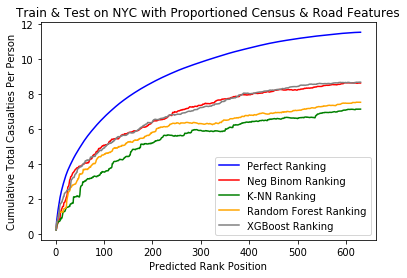

<Figure size 432x432 with 0 Axes>

In [13]:
# NYC census & road data
run_models(
    city = 'NYCr', 
    target_y = 'CasualtiesPerPop', 
    k = 5
)

 
ITERATION:
Train on NYC & Test on LA with Proportioned Census
Target Variable: CasualtiesPerPop
 
MODEL PERFORMANCE
 
TARGET BASELINE
  Shape of training data: (2100, 26)
  Shape of test data: (1095, 26)
  Test Set Stdev: 0.01
  Test Set MAE: 0.01
 
                 Model CV RMSE  Prediction RMSE  Prediction MAE
0    Negative Binomial     n/a          0.02869         0.02206
1  K-Nearest Neighbors 0.04539          0.03154         0.02304
2        Random Forest 0.04013          0.05858         0.04652
3              XGBoost 0.04037          0.07481         0.06019
 
FEATURE IMPORTANCE
 
RF Top 10 Features
pop_dens         0.38615
female           0.08530
trav_cars        0.06378
edu_hsged        0.05183
unemp            0.03496
trav_walk        0.03192
not_us_citizen   0.02888
age_boomer       0.02798
race_minority    0.02637
trav_trans       0.02570
dtype: float64
 
XGBoost Top 10 Features
pop_dens         0.17187
trav_trans       0.07404
edu_hsged        0.06088
trav_cars        0.0

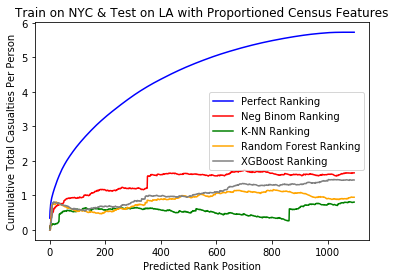

<Figure size 432x432 with 0 Axes>

In [14]:
# Train on NYC and test on LA with census data
run_models(
    city = 'LA', 
    target_y = 'CasualtiesPerPop', 
    k = 5
)

 
ITERATION:
Train on NYC & Test on DC with Proportioned Census & Road Features
Target Variable: CasualtiesPerPop
 
MODEL PERFORMANCE
 
TARGET BASELINE
  Shape of training data: (2100, 26)
  Shape of test data: (178, 26)
  Test Set Stdev: 0.05
  Test Set MAE: 0.03
 
                 Model CV RMSE  Prediction RMSE  Prediction MAE
0    Negative Binomial     n/a          0.04172         0.02603
1  K-Nearest Neighbors 0.04539          0.05330         0.02937
2        Random Forest 0.04035          0.04736         0.02816
3              XGBoost 0.04037          0.05542         0.03681
 
FEATURE IMPORTANCE
 
RF Top 10 Features
pop_dens         0.40415
female           0.07231
trav_cars        0.05686
edu_hsged        0.04408
trav_walk        0.03517
trav_trans       0.03427
age_boomer       0.03319
unemp            0.03268
age_genx         0.02856
not_us_citizen   0.02847
dtype: float64
 
XGBoost Top 10 Features
pop_dens         0.17187
trav_trans       0.07404
edu_hsged        0.06088
trav_

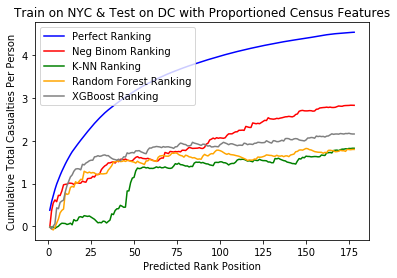

<Figure size 432x432 with 0 Axes>

In [15]:
# Train on NYC and test on DC with census data
run_models(
    city = 'DC', 
    target_y = 'CasualtiesPerPop', 
    k = 5
)

**run_negbinom() and run_ols() instructions:**
* city: select 'NYC', 'Brooklyn', 'Bronx', 'Queens', 'Manhattan', 'Staten Island', 'LA', or 'DC'
* target_y: select 'CasualtiesCount', 'CasualtiesPerPop'
* features: select 'transpo', 'demog', 'census', or 'hypoth'

AIC: 620.2345004661233
                 Generalized Linear Model Regression Results                  
Dep. Variable:       CasualtiesPerPop   No. Observations:                 2100
Model:                            GLM   Df Residuals:                     2090
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -300.12
Date:                Tue, 30 Apr 2019   Deviance:                       31.638
Time:                        10:28:22   Pearson chi2:                     48.4
No. Iterations:                     5   Covariance Type:             nonrobust
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.6350      1.491     -1.767      0.077      -5.557       0.287
pop_dens      

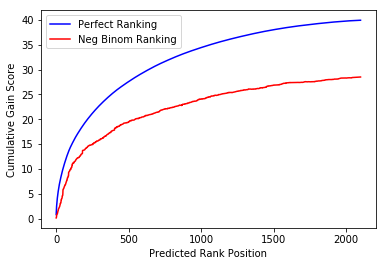

<Figure size 360x288 with 0 Axes>

In [16]:
# Run negative binomial model function
run_negbinom(
    area = 'NYC', 
    target_y = 'CasualtiesPerPop', 
    features = 'hypoth'
)

                            OLS Regression Results                            
Dep. Variable:       CasualtiesPerPop   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     25.38
Date:                Tue, 30 Apr 2019   Prob (F-statistic):           2.90e-31
Time:                        10:28:26   Log-Likelihood:                 595.54
No. Observations:                 275   AIC:                            -1171.
Df Residuals:                     265   BIC:                            -1135.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0233      0.022     

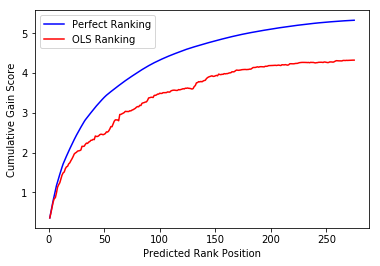

<Figure size 360x288 with 0 Axes>

In [17]:
# Run OLS model function
run_ols(
    area = 'Manhattan', 
    target_y = 'CasualtiesPerPop', 
    features = 'hypoth'
)